### Notebook creado por **Guillermo Grande Santi**

# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import logging
import math
from collections import Counter
# from scipy.stats import norm

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.ensemble import RandomForestClassifier 
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import GridSearchCV, cross_val_score
import pickle

import tensorflow as tf
from tensorflow.keras.models import Sequential # type: ignore
from tensorflow.keras.layers import LSTM, Dense # type: ignore
from tensorflow.keras.preprocessing.sequence import pad_sequences # type: ignore
from tensorflow.keras.preprocessing.text import Tokenizer # type: ignore

# import torch
# import torch.nn as nn
# import torch.optim as optim
# from torch.utils.data import DataLoader, TensorDataset
# import torch.backends.cudnn as cudnn

# from sentence_transformers import SentenceTransformer
# from transformers import AutoTokenizer, AutoModel
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess
import nltk
import re
import string
import spacy
import contractions

import shap

2025-06-05 15:50:59.105286: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749131459.194713     743 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749131459.223437     743 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1749131459.421795     743 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1749131459.421818     743 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1749131459.421820     743 computation_placer.cc:177] computation placer alr

# División Train, Valid y Test

In [2]:
# Cargar el DataFrame limpio
df = pd.read_csv("../Datasets/Cleaned-FR-News_V2.csv")

# Dividimos los datos en entrenamiento y prueba
# Por ahora usaremos únicamente el texto de la noticia (omitimos el título)
X = df["clean_text"]
y = df["label"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Se usará para redes neuronales
# Usaremos un 20% del conjunto de datos para validación (16% del total)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Explicabilidad

### Modelo con Tensorflow para facilitar explicabilidad - Batch 128

In [3]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
def create_dataset(train, test, shuffle=True):
    # Create a TensorFlow dataset from the text and fake columns of the dataframe
    dataset = tf.data.Dataset.from_tensor_slices((train, test))
    if shuffle:
         # Shuffle the dataset if the shuffle parameter is True
        dataset = dataset.shuffle(1024, reshuffle_each_iteration=True)
    # Batch the dataset into smaller batches of size 256
    dataset = dataset.batch(128).cache().prefetch(tf.data.AUTOTUNE)
    # Prefetch the next batch of data to further optimize training
    return dataset

train_ds = create_dataset(X_train, y_train)
valid_ds = create_dataset(X_valid, y_valid, shuffle=False)
test_ds = create_dataset(X_test, y_test, shuffle=False)

I0000 00:00:1749131479.004040     743 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5592 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060 Ti, pci bus id: 0000:05:00.0, compute capability: 8.6


In [5]:
# Create a TextVectorization layer with specified parameters
vectorizer = tf.keras.layers.TextVectorization(
    max_tokens=10000, 
    output_sequence_length=1024,
    pad_to_max_tokens=True,
)
# Adapt the TextVectorization layer to the training data
vectorizer.adapt(X_train, batch_size=1024)

In [6]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(), dtype=tf.string),
    vectorizer,
    tf.keras.layers.Embedding(
        input_dim=10000, 
        output_dim=64,
        input_length=1024, 
        mask_zero=True
    ),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)), 
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)), 
    tf.keras.layers.Dense(16, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid")
])
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(), 
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), 
    metrics=[
        "accuracy", 
        tf.keras.metrics.AUC(name="auc")
    ]
)
model.summary()
tf.keras.utils.plot_model(model)

/home/ggs/Fake-News-Detection/.venv/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization              │ (None, 1024)           │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 1024, 64)       │       640,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 1024, 128)      │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 64)             │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 748,321 (2.85 MB)

 Trainable params: 748,321 (2.85 MB)

 Non-trainable params: 0 (0.00 B)

You must install pydot (`pip install pydot`) for `plot_model` to work.


In [8]:
# Verificación rápida
import tensorflow as tf
print("Asignación de ops en dispositivos:")
tf.debugging.set_log_device_placement(True)

file_path = "../models/best_bilstm_test.keras"
history = model.fit(
    train_ds,
    epochs=10, 
    validation_data=valid_ds,
    callbacks=[
        tf.keras.callbacks.ModelCheckpoint(
            file_path,
            save_best_only=True,
            monitor='val_accuracy',
            mode='max'
        )
    ]
)

Asignación de ops en dispositivos:
Epoch 1/10
221/221 ━━━━━━━━━━━━━━━━━━━━ 57s 258ms/step - accuracy: 0.9825 - auc: 0.9969 - loss: 0.0597 - val_accuracy: 0.9890 - val_auc: 0.9988 - val_loss: 0.0385
Epoch 2/10
221/221 ━━━━━━━━━━━━━━━━━━━━ 59s 267ms/step - accuracy: 0.9969 - auc: 0.9997 - loss: 0.0127 - val_accuracy: 0.9911 - val_auc: 0.9981 - val_loss: 0.0316
Epoch 3/10
221/221 ━━━━━━━━━━━━━━━━━━━━ 57s 260ms/step - accuracy: 0.9993 - auc: 1.0000 - loss: 0.0035 - val_accuracy: 0.9932 - val_auc: 0.9977 - val_loss: 0.0271
Epoch 4/10
221/221 ━━━━━━━━━━━━━━━━━━━━ 56s 253ms/step - accuracy: 0.9998 - auc: 1.0000 - loss: 0.0013 - val_accuracy: 0.9934 - val_auc: 0.9980 - val_loss: 0.0270
Epoch 5/10
221/221 ━━━━━━━━━━━━━━━━━━━━ 55s 249ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 3.9358e-04 - val_accuracy: 0.9922 - val_auc: 0.9977 - val_loss: 0.0311
Epoch 6/10
221/221 ━━━━━━━━━━━━━━━━━━━━ 56s 251ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 2.3635e-04 - val_accuracy: 0.9921 - val_auc: 0.997

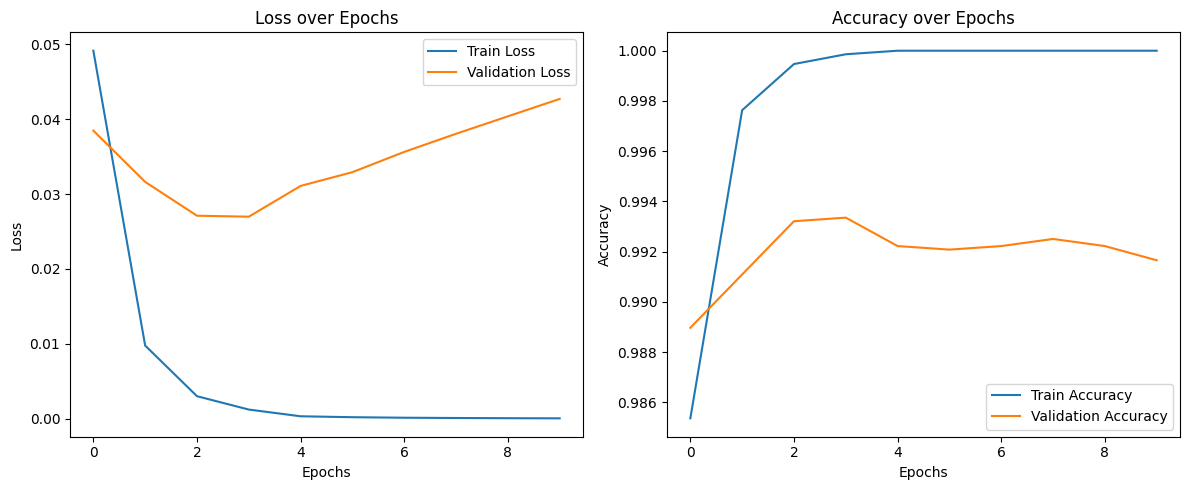

In [9]:
# Plot training and validation loss and accuracy
plt.figure(figsize=(12, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

Consideramos óptimo el modelo que alcanza el máximo valor de *val_accuracy* durante el entrenamiento. En este experimento, la mejor convergencia se produce en la cuarta época, con un val_accuracy del **99,34 %** y una pérdida de **0,027**, lo que supone un ligero progreso respecto al modelo en PyTorch. A continuación, presentamos los resultados obtenidos sobre el conjunto de prueba.

In [11]:
# Evaluate the TensorFlow model using the test_ds dataset
model = tf.keras.models.load_model(file_path)
eval_results = model.evaluate(test_ds)


70/70 ━━━━━━━━━━━━━━━━━━━━ 8s 102ms/step - accuracy: 0.9950 - auc: 0.9991 - loss: 0.0176


En el conjunto de prueba, el modelo alcanza una precisión de **99,50 %**, el mejor resultado obtenido hasta la fecha. El área bajo la curva ROC —que mide la capacidad del modelo para distinguir correctamente entre clases positivas y negativas en todos los umbrales posibles— es de **99,91 %**, y la pérdida final se sitúa en **0,0176**.

Parece que **TensorFlow** no solo resulta ser más adecuado para aplicar explicabilidad a estos modelos, sino que también muestra un rendimiento ligeramente superior al de PyTorch con la misma configuración.



Comentario: El mismo modelo con Tensorflow con un batch de 256 obtiene aproximadamente el mismo rendimiento (99.11 %), por lo que el mejor batch sigue siendo 128.

### Explicabilidad mediante Deep SHAP

Utilizaremos **Deep SHAP** para la **explicabilidad** de nuestra LSTM Bidireccional, un método de explicabilidad que estima cómo cada característica contribuye a las predicciones de un modelo profundo.

- El método *Gradient Explainer de SHAP* utiliza **muestras de fondo** para aproximar valores SHAP de manera eficiente, ya que calcularlos para todos los datos de entrenamiento sería **computacionalmente inviable** en modelos complejos como BiLSTM.

- Además, para usar *Gradient Explainer*, se debe extraer la capa de vectorización, ya que SHAP requiere entradas numéricas (en lugar del texto en bruto). Se crea un submodelo que acepta secuencias de enteros, y se explican predicciones mapeando tokens a sus contribuciones.

- De hecho, la capa de embedding también debe ser extraída porque con *mask_zero=True*, Embedding genera una **máscara de padding** que las LSTM cuDNN rechazan (requieren ceros al final); al usar *mask_zero=False* **eliminamos esa máscara** y **evitamos el chequeo** de cuDNN. Además, los explainers por gradiente necesitan entradas **float32** para calcular derivadas y no admiten IDs enteros, por lo que Deep SHAP comenzará con un tensor float32 de forma (batch_size, 1024, 64) con los embeddings de cada token; la **vectorización (texto→int64)** y la **conversión a embeddings (int32→float32)** se hacen por tanto fuera del modelo.


In [3]:
# ————— 1) Cargamos modelo y extraemos cap —————
model = tf.keras.models.load_model("../models/best_bilstm.keras")
vectorizer     = model.get_layer("text_vectorization")
orig_embedding = model.get_layer("embedding")
bilstm1        = model.get_layer("bidirectional")
bilstm2        = model.get_layer("bidirectional_1")
dense1         = model.get_layer("dense")
dense2         = model.get_layer("dense_1")

In [4]:
# ————— 2) Clonamos el embedding SIN máscara (mask_zero=False) —————
cfg = orig_embedding.get_config()
cfg["mask_zero"] = False # Es necesario para que no haya incompatibilidades de padding
emb_no_mask = tf.keras.layers.Embedding.from_config(cfg)
emb_no_mask.build((None, 1024))
emb_no_mask.set_weights(orig_embedding.get_weights())

# ————— 3) Creamos un sub-modelo que arranca en la salida del embedding —————
seq_len = 1024
emb_input = tf.keras.Input(shape=(seq_len, cfg["output_dim"]), dtype=tf.float32, name="emb_input")
x = bilstm1(emb_input)
x = bilstm2(x)
x = dense1(x)
output = dense2(x)
model_after_emb = tf.keras.Model(inputs=emb_input, outputs=output, name="after_emb")
model_after_emb.summary()

Model: "after_emb"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ emb_input (InputLayer)          │ (None, 1024, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 1024, 128)      │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 64)             │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 108,321 (423.13 KB)

 Trainable params: 108,321 (423.13 KB)

 Non-trainable params: 0 (0.00 B)

In [5]:
# ————— 4) Preparamos background y ejemplo, calculamos sus embeddings —————
#  Usa NumPy para SHAP
bg_texts    = X_train[:250]
bg_ids      = vectorizer(bg_texts).numpy().astype(np.int32)     # shape (100,1024)
bg_emb      = emb_no_mask(bg_ids).numpy()                      # (100,1024,64) float32

# Ejemplo a explicar
text        = X_test.iloc[0]
tok_ids     = vectorizer([text]).numpy().astype(np.int32)      # (1,1024)
tok_emb     = emb_no_mask(tok_ids).numpy()                     # (1,1024,64)

In [6]:
# ————— 5) Creamos el explainer sobre el modelo “after embedding” —————
explainer = shap.GradientExplainer(model_after_emb, [bg_emb])

In [8]:
# ————— 6) Calculamos los valores SHAP del embedding del ejemplo —————
shap_emb_vals = explainer.shap_values(tok_emb)[0] # devuelve un array (1, 1024, 64)

In [13]:
# ————— 7) Colapsamos las 64 dimensiones en un único valor por token (sumando cada dimensión) —————
shap_token_vals = np.sum(shap_emb_vals[0], axis=1)  # shape (1024,)

# ————— 8) Mapeamos IDs → tokens y emparejamos con SHAP —————
vocab      = vectorizer.get_vocabulary()
ids        = tok_ids[0]
token_shap = [
    (vocab[token_id], float(shap_token_vals[i]))
    for i, token_id in enumerate(ids)
    if token_id != 0
]


In [15]:
# ————— 9) Ordenamos por importancia y mostramos top-20 tokens más influyentes en la clasificación de la noticia —————
top20 = sorted(token_shap, key=lambda x: abs(x[1]), reverse=True)[:20]
print("Tokens más influyentes:")
for tok, score in top20:
    print(f"{tok:>15}  {score:.4f}")

Tokens más influyentes:
      judiciary  0.0035
     parliament  0.0031
         choose  0.0031
          broad  0.0024
       national  0.0022
 responsibility  0.0022
         friday  0.0021
         poland  0.0016
        country  0.0014
          still  0.0013
        council  0.0013
         change  0.0012
       approval  0.0012
           rule  0.0012
       overhaul  0.0011
          house  0.0009
           rule  0.0008
          judge  0.0007
       nominate  0.0006
   presidential  0.0006


Clasificación de la noticia: 1


/tmp/ipykernel_9706/1614587616.py:12: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(vals, feature_names=names, plot_type="bar")


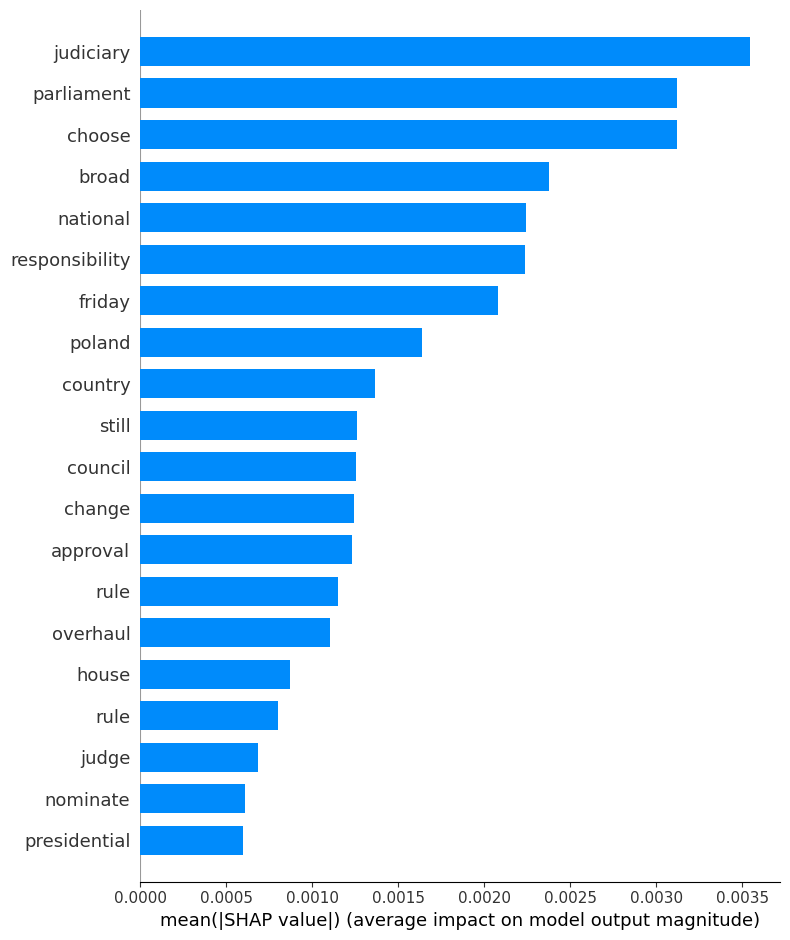

In [25]:
# ————— 10) Summary Plot —————

# Calculamos los índices de los tokens no-padding
nonzero_idx = [i for i, t in enumerate(ids) if t != 0]

# Extraemos sólo esos valores y nombres
vals   = shap_token_vals[nonzero_idx].reshape(1, -1)
names  = [vocab[ids[i]]      for i in nonzero_idx]

# Llamada a summary_plot
print(f"Clasificación de la noticia: {y_test.iloc[0]}")
shap.summary_plot(vals, feature_names=names, plot_type="bar")

#### Mostrando tokens más influyentes en la clasificación de una noticia como verdadera o falsa

Hasta ahora simplemente mostramos los tokens más influyentes, pero al hacer el valor absoluto no podíamos saber hacía que lado de la clasificación estaban influyendo.

In [35]:
shap_emb_vals   = explainer.shap_values(tok_emb)[0]
shap_token_vals = np.sum(shap_emb_vals[0], axis=1)
ids             = tok_ids[0]
vocab           = vectorizer.get_vocabulary()

# Emparejamos tokens con su valor SHAP (con signo)
token_shap = [
    (vocab[token_id], float(shap_token_vals[i]))
    for i, token_id in enumerate(ids)
    if token_id != 0
]

# Separamos positivos y negativos
positive_tokens = sorted(
    [ts for ts in token_shap if ts[1] > 0],
    key=lambda x: x[1],
    reverse=True
)[:10]

negative_tokens = sorted(
    [ts for ts in token_shap if ts[1] < 0],
    key=lambda x: x[1]
)[:10]  # aquí ya vendrán los más negativos al principio

print("Tokens que empujan hacia ‘verdadero’:")
for tok, score in positive_tokens:
    print(f"{tok:>15}  {score:.4f}")

print("\nTokens que empujan hacia ‘falso’:")
for tok, score in negative_tokens:
    print(f"{tok:>15}  {score:.4f}")

/home/ggs/Fake-News-Detection/.venv/lib/python3.11/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: emb_input
Received: inputs=['Tensor(shape=(1, 1024, 64))']
  warnings.warn(msg)


Tokens que empujan hacia ‘verdadero’:
      judiciary  0.0039
         choose  0.0035
     parliament  0.0032
 responsibility  0.0031
          broad  0.0026
       national  0.0024
         poland  0.0024
         friday  0.0022
         system  0.0018
        country  0.0018

Tokens que empujan hacia ‘falso’:
          court  -0.0001
         member  -0.0001
            new  -0.0001
            low  -0.0000


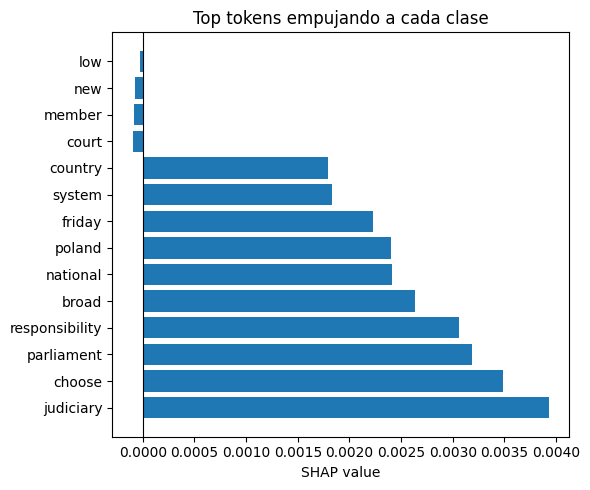

In [36]:
# Combinar para gráfica, alternando color según signo
top_combined = positive_tokens[:10] + negative_tokens[:10]
tokens, scores = zip(*top_combined)
y_pos = range(len(tokens))

plt.figure(figsize=(6, 5))
plt.barh(y_pos, scores)
plt.yticks(y_pos, tokens)
plt.axvline(0, color="k", linewidth=0.8)
plt.title("Top tokens empujando a cada clase")
plt.xlabel("SHAP value")
plt.tight_layout()
plt.show()

Como la noticia es verdadera, se observa claramente que hay SHAP values mucho mayores en tokens que influyen en la clasificación hacia verdadera.

In [48]:
# Crearemos una función para facilitar el proceso
def get_top_shap_tokens(explainer, vectorizer, emb_no_mask, text, true_label, top_n=10):
    """
    Given a SHAP explainer, a raw text string and its true label (0 or 1),
    returns the top_n tokens pushing the model output towards that label.
    """
    # 1) Tokenize and embed the input text
    tok_ids = vectorizer([text]).numpy().astype(np.int32)          # (1, seq_len)
    tok_emb = emb_no_mask(tok_ids).numpy()                         # (1, seq_len, emb_dim)
    # 2) Compute SHAP values on embedding
    shap_emb = explainer.shap_values(tok_emb)[0]                   # (1, seq_len, emb_dim)
    # 3) Sum across embedding dimensions to get one score per token
    shap_token_vals = np.sum(shap_emb[0], axis=1)                  # (seq_len,)
    # 4) Emparejamos tokens con sus valores SHAP, evitando overflow
    vocab = vectorizer.get_vocabulary()
    token_ids = tok_ids[0]
    token_shaps = [
        (vocab[token_id], float(shap_val))
        for token_id, shap_val in zip(token_ids, shap_token_vals)
        if token_id != 0 and vocab[token_id] != "[UNK]"
    ]
    # 5) Separate positive vs. negative contributions
    pos = sorted([ts for ts in token_shaps if ts[1] > 0], key=lambda x: x[1], reverse=True)
    neg = sorted([ts for ts in token_shaps if ts[1] < 0], key=lambda x: x[1])
    # 6) Select top_n tokens driving towards the true_label
    selected = pos[:top_n] if true_label == 1 else neg[:top_n]

    # 7) Plot pushes of those tokens
    tokens, scores = zip(*selected)
    y_pos = list(range(len(tokens)))
    colors = ['green' if s > 0 else 'red' for s in scores]

    plt.figure(figsize=(8, 4))
    plt.barh(y_pos, scores, color=colors)
    plt.yticks(y_pos, tokens)
    plt.axvline(0, color='black', linewidth=0.8)
    plt.gca().invert_yaxis()
    plt.title(f"Top {top_n} tokens pushing towards {'True' if true_label==1 else 'False'}")
    plt.xlabel("SHAP value")
    plt.tight_layout()
    plt.show()

    # 8) Return the list of (token, score)
    return selected

Example 0:
Example text: warsaw  poland low house parliament friday approve change country national judiciary council part broad overhaul court system push rule conservative new rule still need senate presidential approval parliament responsibility choose member council turn nominate judge
True label: 1


/home/ggs/Fake-News-Detection/.venv/lib/python3.11/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: emb_input
Received: inputs=['Tensor(shape=(1, 1024, 64))']
  warnings.warn(msg)


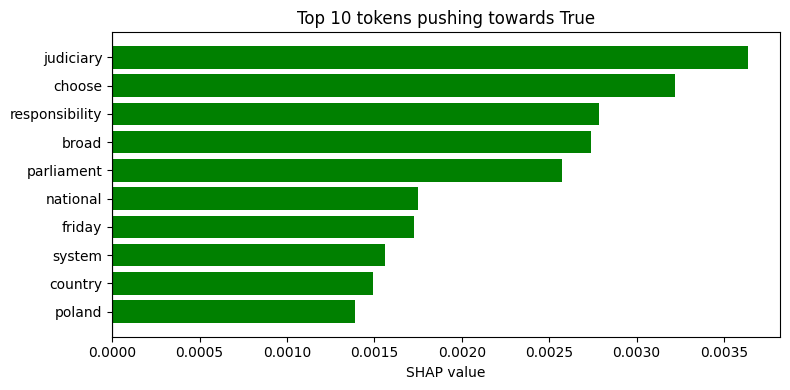

Selected tokens and their SHAP values:
judiciary: 0.0036
choose: 0.0032
responsibility: 0.0028
broad: 0.0027
parliament: 0.0026
national: 0.0018
friday: 0.0017
system: 0.0016
country: 0.0015
poland: 0.0014
----------------------------------------
Example 1:
Example text: washington  roger stone longtime ally president donald trump say thursday agree testify closed hearing house representatives intelligence committee investigation possible russia meddle presidential election member committee present hearing stone informal adviser republican president say statement hearing hold sept stone say ask open public hearing interest full transparency since close request immediate release transcript avoid confusion testimony much look forward testify anxious correct number misstatement committee member regard activity stone say spokeswoman representative mike conaway republican charge committee investigation decline comment house panel one main congressional committee investigate allegation russi

/home/ggs/Fake-News-Detection/.venv/lib/python3.11/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: emb_input
Received: inputs=['Tensor(shape=(1, 1024, 64))']
  warnings.warn(msg)


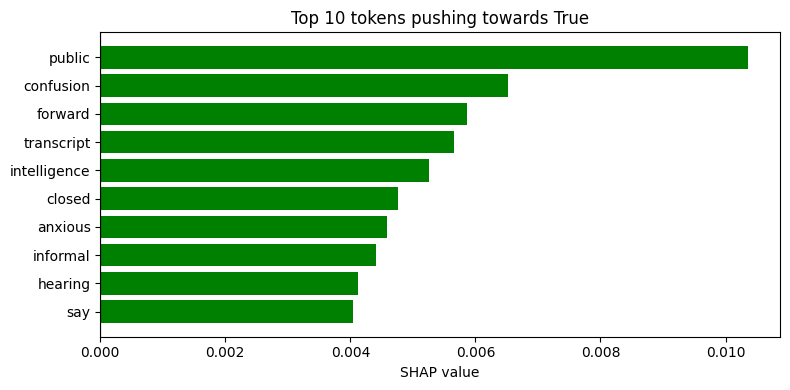

Selected tokens and their SHAP values:
public: 0.0104
confusion: 0.0065
forward: 0.0059
transcript: 0.0057
intelligence: 0.0053
closed: 0.0048
anxious: 0.0046
informal: 0.0044
hearing: 0.0041
say: 0.0040
----------------------------------------
Example 2:
Example text: effect donald trump presidency already start take shape hearing incident racism country people feel trump win give right racist violent wantanother thing remember everything trump promise election one thing ban muslim enter countrythe daily show hasan minaj take threat ban seriously family muslim mother currently countrywhile speak host trevor noah minaj break character correspondent take role concerned citizen look straight camera say true story mom country right visit grandma us citizen live thirty year phone last night like hasan know come back february go able get back country fact tell yes one hundred percent certainty heartbreaking lot people tell hey man worry trump really go ban muslims know man mom need back hom

/home/ggs/Fake-News-Detection/.venv/lib/python3.11/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: emb_input
Received: inputs=['Tensor(shape=(1, 1024, 64))']
  warnings.warn(msg)


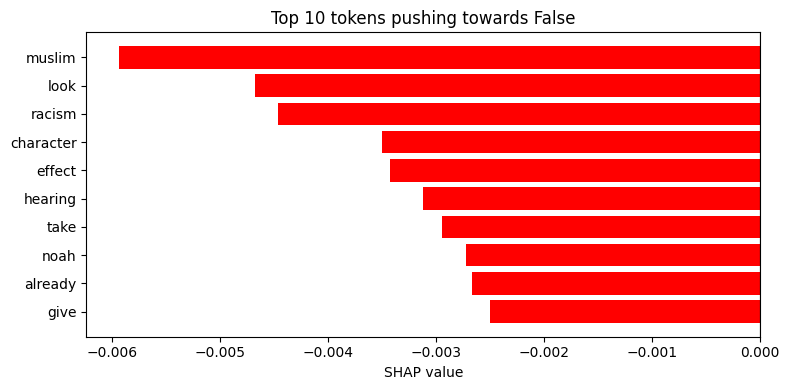

Selected tokens and their SHAP values:
muslim: -0.0059
look: -0.0047
racism: -0.0045
character: -0.0035
effect: -0.0034
hearing: -0.0031
take: -0.0029
noah: -0.0027
already: -0.0027
give: -0.0025
----------------------------------------
Example 3:
Example text: washington  us house representative speaker paul ryan say tuesday applaud new house bill help puerto rico deal billion debt applaud rep duffy introduce hr hold right people accountable crisis shrink size government authorize independent board help get puerto rico path fiscal health ryan say statement
True label: 1


/home/ggs/Fake-News-Detection/.venv/lib/python3.11/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: emb_input
Received: inputs=['Tensor(shape=(1, 1024, 64))']
  warnings.warn(msg)


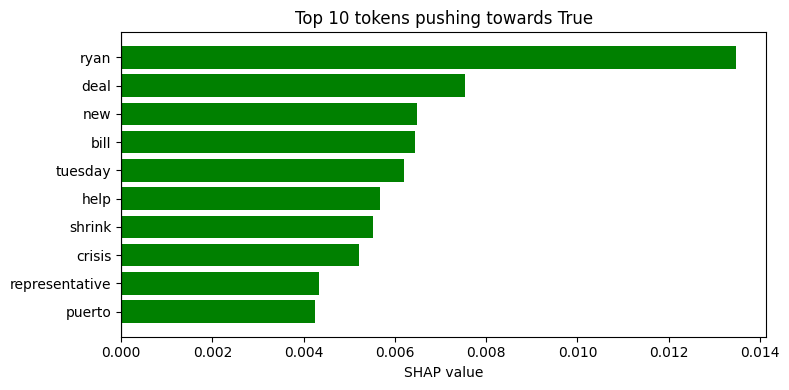

Selected tokens and their SHAP values:
ryan: 0.0135
deal: 0.0075
new: 0.0065
bill: 0.0064
tuesday: 0.0062
help: 0.0057
shrink: 0.0055
crisis: 0.0052
representative: 0.0043
puerto: 0.0042
----------------------------------------
Example 4:
Example text: donald trump successfully tear republican party america apart policy divide americans across country even member party odd president policiesone thing shatter gop grow opposition trump immigration agenda trump campaign bud presidency trump tout border wall mass deportation trump announce somewhat concrete plan high profile republican publicly voice disappointmentone outspoken goper going trump south carolina senator lindsey graham warning trump meritbase immigration plan would disaster state like south carolina graham say statement deal issue decade know restrict legal labor employer incentivize cheat trump announce meritbase system call raise acti campaign create meritbase immigration system protect we worker taxpayer watch raiseact don

/home/ggs/Fake-News-Detection/.venv/lib/python3.11/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: emb_input
Received: inputs=['Tensor(shape=(1, 1024, 64))']
  warnings.warn(msg)


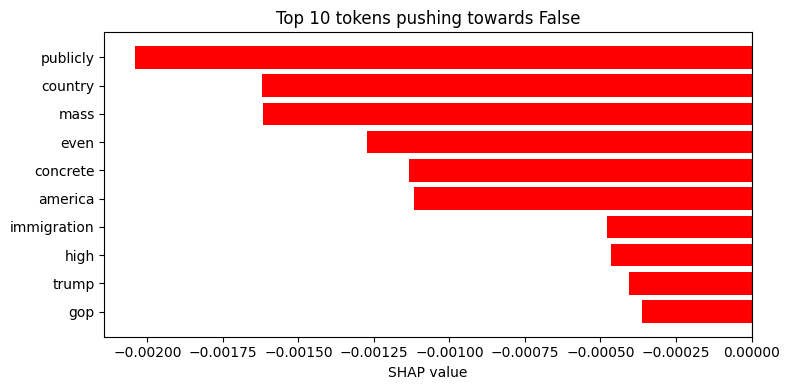

Selected tokens and their SHAP values:
publicly: -0.0020
country: -0.0016
mass: -0.0016
even: -0.0013
concrete: -0.0011
america: -0.0011
immigration: -0.0005
high: -0.0005
trump: -0.0004
gop: -0.0004
----------------------------------------
Example 5:
Example text: strasbourg  european parliament propose wednesday reduce eu funds turkey link stall bid join bloc call eu leader expect back give deteriorate relation ankara million euro set go turkey reform infrastructure agriculture eu lawmakers agree cut million euro million euro cut first reduction turkey improve human right record turkey respect freedom speech freedom expression human right drift away european democratic standard say centreright lawmaker siegfrie muresan lead budget discussion can not pretend see tell  emphasizing cut would affect money earmark political reform infrastructure farming eu leader must still sign cut expect agreement summit last week reduce socalle preaccession aid mean help eu candidate country prepare me

/home/ggs/Fake-News-Detection/.venv/lib/python3.11/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: emb_input
Received: inputs=['Tensor(shape=(1, 1024, 64))']
  warnings.warn(msg)


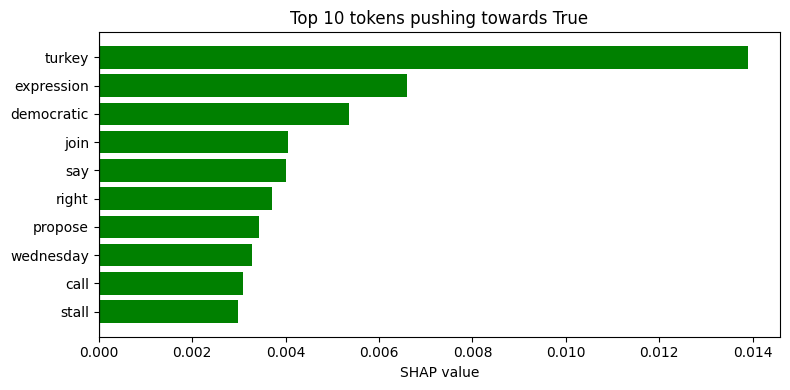

Selected tokens and their SHAP values:
turkey: 0.0139
expression: 0.0066
democratic: 0.0054
join: 0.0041
say: 0.0040
right: 0.0037
propose: 0.0034
wednesday: 0.0033
call: 0.0031
stall: 0.0030
----------------------------------------
Example 6:
Example text: los angeles  comedian kathy griffin tearfully apologize friday press conference pose fake bloody sever head depict we president donald trump saying feel career trump broke griffin lose sponsorship job include role cohost cnn new year eve coverage journalist anderson cooper since photograph video shoot appear social medium tuesday president trump say image griffin gory mask resemble sick traumatize family especially young son barron trump old son donald jr call employer drop comedian think career go honest trump broke say griffin twotime emmywinne performer know deliberately provocative brand humor add receive death threat griffin reiterate apology post social medium late tuesday remain defiant say afraid donald trump he s bully add 

/home/ggs/Fake-News-Detection/.venv/lib/python3.11/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: emb_input
Received: inputs=['Tensor(shape=(1, 1024, 64))']
  warnings.warn(msg)


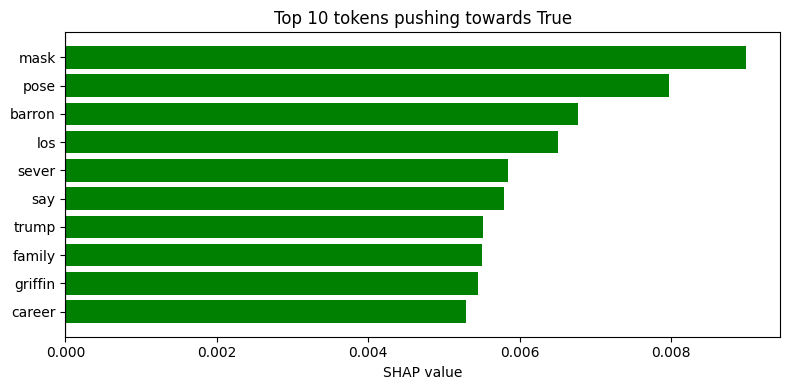

Selected tokens and their SHAP values:
mask: 0.0090
pose: 0.0080
barron: 0.0068
los: 0.0065
sever: 0.0059
say: 0.0058
trump: 0.0055
family: 0.0055
griffin: 0.0054
career: 0.0053
----------------------------------------
Example 7:
Example text: paris  president emmanuel macron monday name awardwinne author leila slimani france top emissary promote use french language appointment old francomoroccan writer emissary francophone affair follow macron decision name tv presenter wellknown ecologist environment minister olympic fencer sport minister open government civil society slimani propel limelight prestigious prix goncourt last year novel chanson douce translate lullaby year publish book sexuality morocco francophone affairs brief past ministerial post junior minister position often occupy career politician macron whose upstart centrist party trounce france traditional political force election early year name series newcomer government nicolas hulot appoint energy environment minister lau

/home/ggs/Fake-News-Detection/.venv/lib/python3.11/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: emb_input
Received: inputs=['Tensor(shape=(1, 1024, 64))']
  warnings.warn(msg)


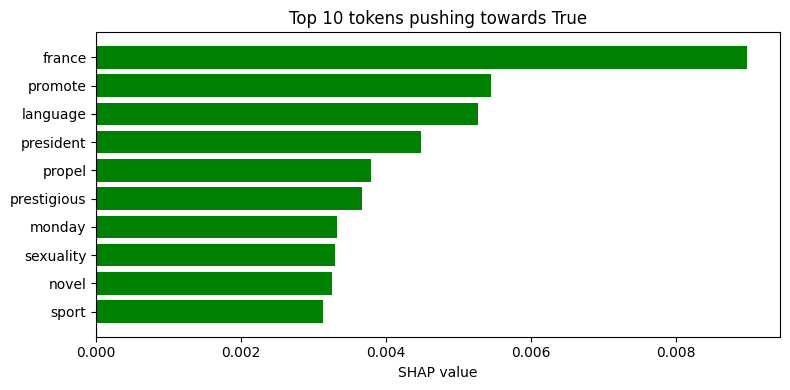

Selected tokens and their SHAP values:
france: 0.0090
promote: 0.0054
language: 0.0053
president: 0.0045
propel: 0.0038
prestigious: 0.0037
monday: 0.0033
sexuality: 0.0033
novel: 0.0033
sport: 0.0031
----------------------------------------
Example 8:
Example text: washington  leading senate democrat tuesday accuse we attorney general jeff sessions conceal policy recommendation could change justice department enforce law illegal immigration drug traffic violent crime letter session oregon democrat ron wyden say justice department release recommendation make task force crime reduction public safety note policy change could end hurt americans decision could dramatic wideranging consequence americans daily life wyden write note task force work could impact everything marijuana asset forfeiture policy hate crime immigration human trafficking yet americans remain dark content task force recommendation task force crime reduction public safety establish executive order president donald trump

/home/ggs/Fake-News-Detection/.venv/lib/python3.11/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: emb_input
Received: inputs=['Tensor(shape=(1, 1024, 64))']
  warnings.warn(msg)


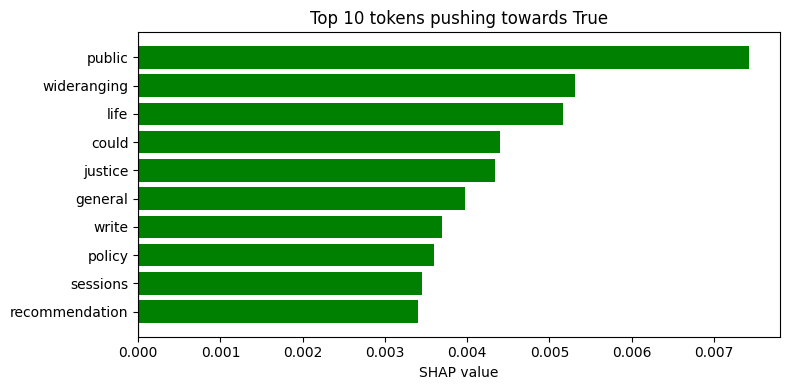

Selected tokens and their SHAP values:
public: 0.0074
wideranging: 0.0053
life: 0.0052
could: 0.0044
justice: 0.0043
general: 0.0040
write: 0.0037
policy: 0.0036
sessions: 0.0035
recommendation: 0.0034
----------------------------------------
Example 9:
Example text: ted cruz keep proving legitimately want president every chance get late dumbassery campaign come national security advisor frank gaffney start lobby member congress refuse meet people participate national muslim advocate daynmad event muslimamericans across nation go washington dc meet representative order voice opinion public policy also make attempt outreach muslimamerican community help bridge cultural gap develop americaseem pretty reasonable right keep hear muslim enough combat threat islamic extremism united states literally every republican however republicans get chance meet muslim something productive turn coward run hideand people say hate we freedom yeah right us council muslim organization release follow statem

/home/ggs/Fake-News-Detection/.venv/lib/python3.11/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: emb_input
Received: inputs=['Tensor(shape=(1, 1024, 64))']
  warnings.warn(msg)


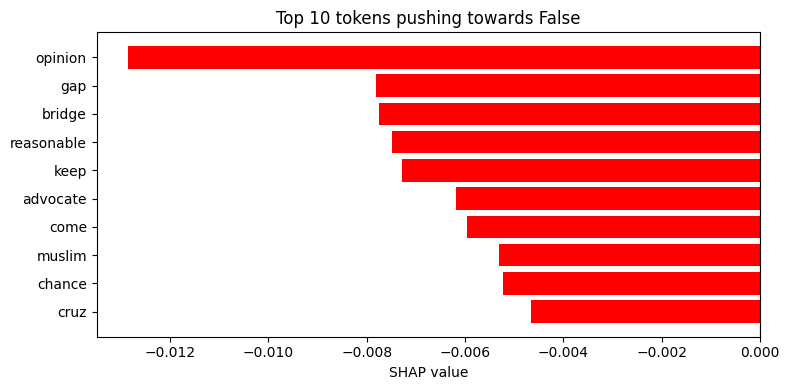

Selected tokens and their SHAP values:
opinion: -0.0128
gap: -0.0078
bridge: -0.0077
reasonable: -0.0075
keep: -0.0073
advocate: -0.0062
come: -0.0060
muslim: -0.0053
chance: -0.0052
cruz: -0.0047
----------------------------------------


In [49]:
top_n = 10

for i in range(10):
    print(f"Example {i}:")
    print("Example text:", X_test.iloc[i])
    print("True label:", y_test.iloc[i])
    selected = get_top_shap_tokens(explainer, vectorizer, emb_no_mask, X_test.iloc[i], y_test.iloc[i], top_n=top_n)
    print("Selected tokens and their SHAP values:")
    for token, score in selected:
        print(f"{token}: {score:.4f}")
    print("-" * 40)

El funcionamiento es sobresaliente: guardemos el modelo para integrarlo en la aplicación web

In [55]:
# Como no se puede guardar el explainer de SHAP, guardamos el modelo y los datos background con los que se creó
model_after_emb.save("models/model_after_emb_explainability.keras")

np.save("models/background_explainability.npy", bg_emb)

Posteriormente, lo cargaremos con:

1. **Cargar el modelo**  
    ```python
    model = keras.models.load_model("models/model_after_emb_explainability.keras")
    ```

2. **Cargar el background** (recomendado: usar `.npy` en vez de `pickle`)  
    ```python
    bg_emb = np.load("models/background_explainability.npy")
    ```

3. **Reinicializar el explainer**  
    ```python
    explainer = shap.DeepExplainer(model, bg_emb)
    ```